In [6]:
from IPython.display import Image as ImageNotebook
from PIL import Image
import numpy as np
from data.train_generator import claptcha
import random
import io
import os
from os.path import join
import cv2
from functools import reduce
import matplotlib.pyplot as plt

domain to break  is https://restaurantpass.gift-cards.ru/balance

#### Parameters Configuration

In [13]:
NUMBER_CHARS_PER_IMAGE = 5
PATH_TEST_DATA = "data/test"

target_image_path = 'data/test/2bbee.png'
target_image = Image.open(target_image_path) 
target_width, target_height = target_image.size

possible_characters = 'abcdefghijklmnopqrstuvwxyz' + '0123456789'
char2ind = dict((ch,i) for i,ch in enumerate(possible_characters))
ind2char = dict((i,ch) for i,ch in enumerate(possible_characters))
NUM_CLASSES = num_classes = len(possible_characters)

font_path = "data/train_generator/fonts/DINNextRoundedLTPro-Regular.otf"

In [14]:
target_image.size

(115, 45)

In [15]:
def randomString(possible_characters, lenght=5):
    rndLetters = (random.choice(possible_characters) for _ in range(lenght))
    return "".join(rndLetters)

In [16]:
def generate_example(possible_characters,lenght=5):
    string = randomString(possible_characters,lenght=lenght)
    c = claptcha.Claptcha(source=string, font=font_path, 
                      margin=(10,10), noise=0, 
                      size=(target_width, target_height))
    _, bytes = c.bytes
    bytes = bytes.read()
    image = Image.open(io.BytesIO(bytes))
    array = np.array(image)
    return array, string, bytes

wz84v


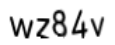

In [162]:
array, string, byte = generate_example(possible_characters, lenght=5)
print (string)
ImageNotebook(data=byte)

In [28]:
def get_locations(image):
    """
    get locations in format (x, y, w, h) of characters on image
    """
    
    # Convert image to grayscale and find counters
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # threshold the image (convert it to pure black and white)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # find the contours (continuous blobs of pixels) the image
    _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    locations = []
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        locations.append((x, y, w, h))
        
    # Sort the detected letter images based on the x coordinate
    locations = sorted(locations, key=lambda x: x[0])
    return locations


def clipper(image, locations):
    """
    clip image based on locations and do some preprocessing
    """
    
    # filter I: overlapping letters
    # split letters if they are overlapping 
    locations_temp = []
    for x, y, w, h in locations:
        # Compare the width and height of the contour to detect letters that
        # are conjoined into one chunk
        if w / h > 1.75:
            # This contour is too wide to be a single letter!
            # Split it in half into two letter regions!
            half_width = int(w / 2)
            locations_temp.append((x, y, half_width, h))
            locations_temp.append((x + half_width, y, half_width, h))
        else:
            locations_temp.append((x, y, w, h))
    locations = locations_temp
    
    # filter II: 'i' case:
    # usually, character 'i' is presented as 2 small images
    # in this case we should concat 2 images at vertical line
    # 1. detect problem: if x1 almost equals x2
    i = 0
    while i < len(locations) - 1:
        x1, y1, w1, h1 = locations[i]
        x2, y2, w2, h2 = locations[i+1]
        if abs(x2 - x1) <= 5:
            # concat 2 elements
            x = min(x1, x2)
            y = min(y1, y2)
            w = max(x1 + w1, x2 + w2) - x
            h = max(y1 + h1, y2 + h2) - y
            locations[i] = (x,y,w,h)
            del locations[i+1]
        else:
            i += 1
           
    # Generate images corresponded to each label in numpy format
    small_images = []
    n = 2 # number of extra pixels
    for x, y, w, h in locations:
        image_char = image[y - n:y + h + n, x - n:x + w + n]
        small_images.append(image_char)
    return small_images


def resize_one(image, shape=(40,40,3)):
    "resize with stretching a figure"
    height, width = shape[:2]
    resized = cv2.resize(image, (width, height), interpolation = cv2.INTER_NEAREST)
    return resized


def resize_one(image, shape=(32,32,3)):
    """ resize without stretching a figure and 
    place the image to the upper-right corner of figure of shape `shape` """
    h_target, w_target = shape[:2]
    h, w = image.shape[:2]
    k = min(h_target/h, w_target/w)
    h_temp, w_temp = int(h * k), int(w * k)
    resized_temp = cv2.resize(image, (w_temp, h_temp), interpolation = cv2.INTER_NEAREST)
    empty = np.full(shape=shape, fill_value=255, dtype=np.uint8)
    empty[:h_temp,:w_temp,:] = resized_temp[:h_target,:w_target,:]
    return empty


def resize_set(small_images, shape=(40,40,3)):
    """ 1. place the image to the upper-right corner of figure of shape `shape`  """
    """ 2. stack images into 1 numpy array """
    images = []
    for small_image in small_images:
        temp = resize_one(small_image, shape=shape)
        images.append(temp)
    return images


def OHE(items, char2ind):
    shape = (len(items),len(char2ind))
    arr = np.zeros(shape=shape, dtype=int)
    for i, el in enumerate(items):
        ind = char2ind[el]
        arr[i,ind] = 1
    return arr


def black_and_white_list(images):
    black_white = []
    for image in images:
        # gray scale image:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # convert image to binary:
        thresh, image_bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
        black_white.append(image_bw)
    return black_white


def process_picture(image_array):
    locations = get_locations(image_array)
    small_images = clipper(image_array, locations)
    x = resize_set(small_images, shape=(32,32,3))
    x = black_and_white_list(x)     # get 1 channel images (n,n,3) -->  (n,n)
    x = [np.expand_dims(el, axis = 0) for el in x]    # (n,n) --> (1,n,n)
    x = np.stack(x)
    x = x/255.   # rescale to [0,1]
    return x.astype(np.float32)

**analysis of each function**

In [19]:
array, string, byte = generate_example(possible_characters, 
                                       lenght=NUMBER_CHARS_PER_IMAGE)

original: ngme6


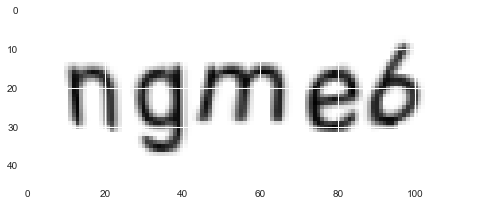

In [21]:
print ("original: {}".format(string))
plt.imshow(array); plt.show();

clipped


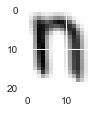

In [22]:
locations = get_locations(array)
small_images = clipper(array, locations)
print ("clipped")
fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(small_images[0]); plt.show();

resized:


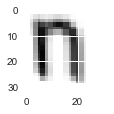

In [23]:
shape=(32,32,3)
height, width = shape[:2]
resized = cv2.resize(small_images[0], (width, height), interpolation = cv2.INTER_NEAREST)
resized = resize_one(small_images[0], shape=shape)

print ('resized:')
fig = plt.figure(figsize=(1.5,1.5))
plt.imshow(np.squeeze(resized)); plt.show();

string = c8pzy

Original:


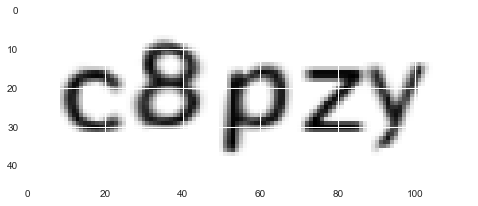

Clipped:


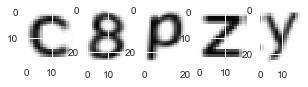

Padded:


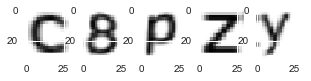

In [24]:
array, string, byte = generate_example(possible_characters, 
                                       lenght=NUMBER_CHARS_PER_IMAGE)

print ("string = {}\n".format(string))
image = array
locations = get_locations(image)
small_images = clipper(image, locations)
small_images_resize = resize_set(small_images, shape=(32,32,3))
small_images_resize = np.stack(small_images_resize)

print ("Original:")
plt.imshow(image); plt.show();

print ("Clipped:")
num = len(small_images)
fig, ax = plt.subplots(nrows=1, ncols=num, figsize=(num,1))
for i, el in enumerate(small_images):
    ax[i].imshow(el)    
plt.show()

print ("Padded:")
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(5,1))
for i in range(5):
    ax[i].imshow(small_images_resize[i])    
plt.show()

number of test examples is 55
number of test examples is 55
string = xew6g

Original:


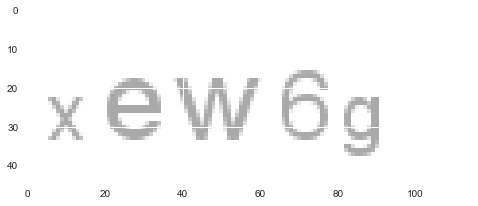

Clipped:


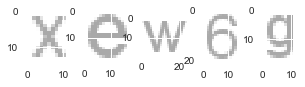

Padded:


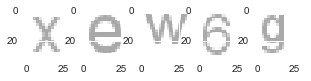

In [29]:
array, string, byte = generate_example(possible_characters, 
                                       lenght=NUMBER_CHARS_PER_IMAGE)

X_test, y_test = Test_Loader().upload_test_set(PATH_TEST_DATA)
i = random.choice(list(range(len(X_test))))
array = X_test[i]
string = y_test[i]


print ("string = {}\n".format(string))
image = array
locations = get_locations(image)
small_images = clipper(image, locations)
small_images_resize = resize_set(small_images, shape=(32,32,3))
small_images_resize = np.stack(small_images_resize)

print ("Original:")
plt.imshow(image); plt.show();

print ("Clipped:")
num = len(small_images)
fig, ax = plt.subplots(nrows=1, ncols=num, figsize=(num,1))
for i, el in enumerate(small_images):
    ax[i].imshow(el)    
plt.show()

print ("Padded:")
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(5,1))
for i in range(5):
    ax[i].imshow(small_images_resize[i])    
plt.show()

### create Dataloader

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader

class TrainLoader(Dataset):
    def __init__(self):
        pass

    @staticmethod
    def generate_train_example():
        image_array, string, _ = generate_example(possible_characters, 
                        lenght=NUMBER_CHARS_PER_IMAGE)
        x = process_picture(image_array)
        y = OHE(string, char2ind)
        return x[0], y[0]
    
    def __getitem__(self, index):
        return self.generate_train_example()

    def __len__(self):
        return int(1e15)  # inf

    
class Test_Loader(Dataset):
    def __init__(self):
        X_test, y_test = self.upload_test_set(PATH_TEST_DATA)
        X = []; Y = []
        for image_array, string in zip(X_test, y_test):
            x = process_picture(image_array)
            y = OHE(string, char2ind)
            if not len(x) == len(y) == NUMBER_CHARS_PER_IMAGE:
                continue
            X.append(x)
            Y.append(y)
        self.X = np.vstack(X)
        self.Y = np.vstack(Y)

    @staticmethod
    def upload_test_set(path):
        x_backet = []
        y_backet = []
        files = os.listdir(path)
        print ("number of test examples is {}".format(len(files)))
        for f in files:
            image = Image.open(join(path, f))
            x = np.array(image)
            y = f.split('.')[0]  # cut '.png'
            x_backet.append(x)
            y_backet.append(y)
        return x_backet, y_backet
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return len(self.X)

### CNN Network

In [31]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

** Awesome Example:** <br>
https://github.com/pytorch/examples/blob/master/mnist/main.py

In [32]:
# Hyper Parameters
batch_size = 100
num_steps = 100
num_epochs = 5
learning_rate = 0.0001

In [33]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self._num_classes = num_classes
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Dropout2d(p=0.15),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Sequential(
            nn.Linear(8 * 8 * 32, 120),
            nn.Dropout(p=0.15),
            nn.Linear(120, self._num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = F.log_softmax(out, dim=1)
        return out

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [34]:
from scipy.sparse import coo_matrix
import seaborn as sns
import pandas as pd

def confusion_matrix(y_true, y_pred, num_classes):
    row  = y_true
    col  = y_pred
    data = np.ones_like(col)
    CM = coo_matrix((data, (row, col)), shape=(num_classes, num_classes))
    return CM.toarray()
 
def plot_conf_matrix(CM, name="confuse_matrix_train.png"):
    df_cm = pd.DataFrame(CM, index = [i for i in possible_characters],
                  columns = [i for i in possible_characters])
    plt.figure(figsize = (14,10))
    sns.heatmap(df_cm, annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    #plt.savefig(name)
    plt.show()

def train(plot=False):
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    learning_rate = 0.00001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the Model
    model.train()
    total_conf_matrix = None
    total = correct = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels) # OHE
        _, labels = labels.max(dim=1)   # to indexes

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Step [%d/%d], Example [%d/%d] Loss: %.5f Accuracy %0.2f %%' 
                   %(i+1, num_steps, (i+1)*batch_size, num_steps*batch_size, loss.data[0], 100 * correct / total))
            #print('Test Accuracy of the model on the %d test images: %d %%' % (total, 100 * correct / total))
            total = 0; correct = 0;
        
        # at the end of training, start to collect confusion matrix statistic 
        if i > num_steps*0.9:
            if total_conf_matrix is None:
                total_conf_matrix = confusion_matrix(labels.data, predicted, NUM_CLASSES)
            else:
                total_conf_matrix += confusion_matrix(labels.data, predicted, NUM_CLASSES)

        if i > num_steps:
            if plot:
                plot_conf_matrix(total_conf_matrix)
            break
                
def eval_model(plot=False):
    correct = total = 0
    total_conf_matrix = None
    model.eval()
    for images, labels in test_loader:
        _, labels = labels.max(dim=1)
        images = Variable(images)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
        if total_conf_matrix is None:
            total_conf_matrix = confusion_matrix(labels, predicted, NUM_CLASSES)
        else:
            total_conf_matrix += confusion_matrix(labels, predicted, NUM_CLASSES)

    print('Test Accuracy of the model on the %d test images: %.2f %%' % (total, 100 * correct / total))
    print ("precision for 5 correct answers: ", (correct / total)**5)
    if plot:
        plot_conf_matrix(total_conf_matrix)

In [38]:
train_loader = DataLoader(dataset=TrainLoader(),
                         batch_size=20, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=Test_Loader(),
                         batch_size=20, shuffle=False, num_workers=4)
model = CNN(num_classes=num_classes)
print ("number of parameters is {}".format(model.count_parameters()))
if torch.cuda.is_available():
    model = model.cuda()

number of test examples is 55
number of parameters is 263580


Step [100/100], Example [10000/10000] Loss: 3.48382 Accuracy 5.45 %


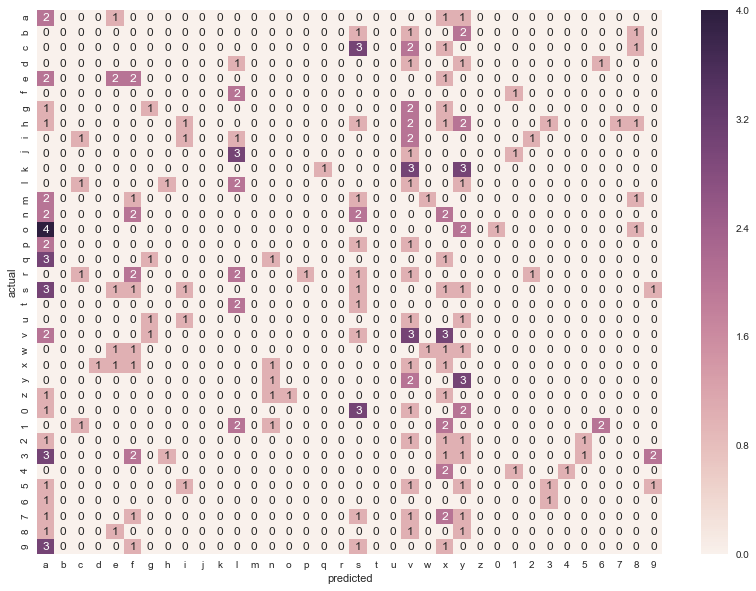

In [36]:
train(plot=1)

Test Accuracy of the model on the 275 test images: 0.00 %
precision for 5 correct answers:  0.0


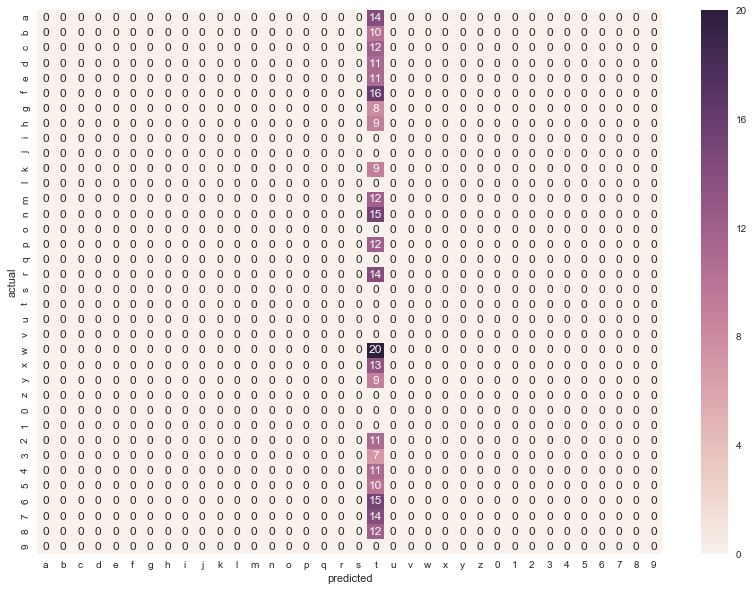

In [39]:
eval_model(plot=1)

In [40]:
# Save the Trained Model
torch.save(model.state_dict(), 'models/model.pkl')

In [41]:
print (model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Dropout2d(p=0.15)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=120, bias=True)
    (1): Dropout(p=0.15)
    (2): Linear(in_features=120, out_features=36, bias=True)
  )
)


In [122]:
import config
from models import models
import train
import torch
from torch.autograd import Variable

In [123]:
model = models.CNN(num_classes=config.NUM_CLASSES)
model.load_state_dict(torch.load(config.model_path))

In [125]:
X,Y = a.upload_test_set(PATH_TEST_DATA)

example = X[15]
string = Y[15]
print (string)
examples = process_picture(example)

for el in examples:
    el = np.expand_dims(el, axis=0)
    tenz = Variable(torch.from_numpy(el))
    outputs = model(tenz)
    _, predicted = torch.max(outputs.data, 1)
    print (ind2char[predicted.numpy()[0]], end = "")
print()

number of test examples is 55
rxb58
rxb58


In [130]:
model = models.CNN(num_classes=config.NUM_CLASSES)
model.load_state_dict(torch.load(config.model_path))


def predict_image(image):
    """
    input: numpy array of shape (45,115,3)   #WHAT ABOUT OTHER SIZE?
    outputs: predicted word
    """
    small_images = process_picture(image)
    result = []
    for img in small_images:
        img = np.expand_dims(img, axis=0)
        tenz = Variable(torch.from_numpy(img))
        outputs = model(tenz)
        _, predicted = torch.max(outputs.data, 1)
        char = ind2char[predicted.numpy()[0]]
        result.append(char)
    return "".join(result)

In [132]:
for img, string in zip(X,Y):
    pred = predict_image(img)
    print (string, pred, string == pred)

r3dpm r3dpm True
ncy28 ncy28 True
5mwcf 5mwcf True
mn8hb mn8hb True
7mcc6 7mcc8 False
2bbee 2bbee True
a7wmc a7wmc True
6p57m 8p57m False
7dry2 7dry2 True
4a4a7 4a4a7 True
xeffw xeffw True
xrg7e xrg7e True
brprw brprw True
g6gfp g8gfp False
a482r a482r True
rxb58 rxb58 True
enny4 enny4 True
nw6wb nw8wb False
fwf5h fwf5h True
ea6p6 ea6p8 False
yfhyd yfhyd True
64w54 84w54 False
bkgnc bkgnc True
7dae8 7dae8 True
7wkr7 7wkr7 True
45rnc 45rnc True
aa32d aa32d True
fepx5 fepx5 True
kd5rm kd5rm True
fh7wf fh7wf True
a5r3r a5r3r True
y6rm7 y8rm7 False
xew6g xew8g False
8p5wd 8p5wd True
nhepp nhepp True
48766 48788 False
fa84b fa84b True
xckka xckka True
xm3w4 xm3w4 True
xhxcg xhxcg True
6r72y 8r72y False
nw66n nw88n False
gcknm gcknm True
dw3dn dw3dn True
xew3w xew3w True
6hf2x 8hf2x False
a8wfw a8wfw True
fh8fb fh8fb True
7gf22 7gf22 True
h2nwn h2nwn True
c2xxc c2xxc True
p3k4k p3k4k True
8yadk 8yadk True
8adyp 8adyp True
pmmbn pmmbn True


### interaction with site

In [225]:
link = "https://restaurantpass.gift-cards.ru/balance"
card_number = "123456789"

In [226]:
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
import time
import os
import sys
import datetime
import random
import logging
import yaml
import importlib
from pyvirtualdisplay import Display


def wait(mean):
    stddev = mean*0.2
    t = random.normalvariate(mean, stddev)
    mintime = random.uniform(0.05,0.15)
    t = max(t, mintime)
    time.sleep(t)


def init_phantomjs_driver(user_agent=None):
    if not user_agent:
        user_agent = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "\
                     "(KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36"
    headers = {
              'Accept': 'text/html,application/xhtml+xml,application'\
                       '/xml;q=0.9,image/webp,*/*;q=0.8',
              'Accept-Language': 'en-US,en;q=0.8,ru;q=0.6',
              'Cache-Control': 'max-age=0',
              'Connection': 'keep-alive'
               }
    for key, value in headers.items():
        big_key = 'phantomjs.page.customHeaders.{}'.format(key)
        webdriver.DesiredCapabilities.PHANTOMJS[big_key] = value
    webdriver.DesiredCapabilities.PHANTOMJS['phantomjs.page.settings.userAgent'] = user_agent
    service_args = ['--ignore-ssl-errors=true', '--ssl-protocol=ANY']
    driver_start = webdriver.PhantomJS(service_args=service_args)
    driver_start.set_window_size(1855, 1056)
    #driver_start.maximize_window()
    return driver_start


def start_chrome(mode="Chrome", user_agent=None):

    if mode == "Chrome":
        options = webdriver.ChromeOptions()
        options.add_argument('--start-maximized')
        driver_start = webdriver.Chrome(chrome_options=options)

    if mode == "PhantomJS":
        driver_start = init_phantomjs_driver(user_agent=user_agent)

    if mode == "FireFox":
        display = Display(visible=0, size=(1855, 1056))
        display.start()
        driver_start = webdriver.Firefox()
    wait(5)

    driver_start.set_page_load_timeout(900)
    driver_start.set_script_timeout(900)
    print ("browser {} is launched".format(mode))
    return driver_start

In [227]:
driver_start = start_chrome()

browser Chrome is launched


In [228]:
driver_start.get(link)

In [229]:
# enter card number
el = driver_start.find_element_by_css_selector('#ean')
el.send_keys(card_number) # create custom send elements

In [230]:
# get captcha imge:
el = driver_start.find_element_by_css_selector('#checkBalanceForm > div.b-check-balance-form_field-block.b-check-balance-form_field-block__captcha > div.b-check-balance-form_field-wrapper > img')

In [231]:
src = el.get_attribute('src')

In [232]:
src

'https://restaurantpass.gift-cards.ru/captcha;jsessionid=2EE275628612966E27B6C93C902A0F55?1523798040384'

In [233]:
import urllib.request
urllib.request.version = 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36 SE 2.X MetaSr 1.0'
file_name, _ = urllib.request.urlretrieve(src)
image = Image.open(file_name)
array = np.asarray(image)

In [234]:
pred = predict_image(array)
pred

'f4fp5'

In [235]:
# ented code:
el = driver_start.find_element_by_css_selector('#captcha')
el.send_keys(pred)

In [236]:
# click 'check balance'
el = driver_start.find_element_by_css_selector(
    '#checkBalanceForm > div.b-check-balance-form_footer > button > span')
el.click()

In [238]:
from bs4 import BeautifulSoup


In [245]:
html_source = driver_start.page_source
soup = BeautifulSoup(html_source, 'lxml')
dashboard_myalphas = soup.find(class_= "b-customer-info_balance_value ng-binding")
text = dashboard_myalphas.get_text()

In [246]:
text

'1 847,15 руб.'